##### Introduction

Geocoding is the process of converting a place name, address, city, state or zip code into geographic coordinates (latitude and longitude). 

If you have ever looked up a geographic location based on a landmark description with Geogle Maps, Bing Maps or Baidu Maps, for instance, then you have used a geocoder.

In Python, geocoding can be done using libraries such as Geopy or ArcGIS API. 

The basic steps are:
- Install the library
- Create an API key (if required) and 
- Use the library's functions to convert the address into latitude and longitude coordinates. 

##### Example - Interactive Map of Museums in Mexico City

Here is an example of using Geopy.

In [24]:
# Set up the notebook (Import lybraries)
from geopy.geocoders import Nominatim
import pandas as pd
import numpy as np
import geopandas as gpd
import folium
from folium import Choropleth, Circle, Marker, FeatureGroup
from folium.plugins import HeatMap, MarkerCluster, LocateControl
import json
from shapely.geometry import shape, Point
from bs4 import BeautifulSoup

First we create a geolocator object using the Nominatim geocoder, Nominatim refers to the geocoding software that will be used to generate locations.

Then, we need only apply the name or address as a Python string. (In this case we supply "Museo Diego Rivera Anahuacalli").

If the geocoding is successful, it returns a geopy.location.Location object with two important attributes:

the "point" attribute contains the (latitude, longitude) location, and
the "address" attribute contains the full address.

In [25]:
# Create a geolocator object
geolocator = Nominatim(user_agent="kaggle_learn")
location = geolocator.geocode("Museo Nacional de la Cartografia")

print(location.point)
print(location.address)

19 24m 15.6595s N, 99 11m 30.3672s W
Museo Nacional de la Cartografía, 94, Periférico Boulevard Adolfo López Mateos, Colonia Observatorio, Ciudad de México, 11870, México


In [26]:
point = location.point
print("Latitude:", point.latitude)
print("Longitude:", point.longitude)

Latitude: 19.404349850000003
Longitude: -99.19176865524628


It's often the case that we'll need to geocode many different addresses. For instance, say we want to obtain the locations of the museums in Mexico City.

The data used in this project is stored in the museums_Mexico_City.csv file. This file contains for each museum: the name, image URL, website URL, as well as data about if the museum has terrace and I have visit it.

We load the data in a pandas DataFrame.

In [29]:
# Load Data
museums = pd.read_csv("DataSet/museums_Mexico_City.csv", encoding="latin-1")
museums.head()

,Museum,TownHall,Terrace,Image,Visited,WebSite
0,Museo de El Carmen,Alvaro Obregón,0,MCdMx1,0,https://lugares.inah.gob.mx/es/museos-inah/mus...
1,Museo Soumaya,Alvaro Obregón,0,MCdMx2,1,http://www.museosoumaya.org/
2,Museo Casa del Risco,Alvaro Obregón,0,MCdMx3,0,https://www.museocasadelrisco.org.mx/
3,Museo Casa Estudio Diego Rivera y Frida Kahlo,Alvaro Obregón,0,MCdMx4,0,https://inba.gob.mx/recinto/51
4,Museo Nacional de Historia Castillo de Chapult...,Miguel Hidalgo,0,MCdMx5,1,https://mnh.inah.gob.mx/


Then we define a function to geocode museum name (we use a try/except statement to account for the case that the geocoding is unsucessful), and we use a lambda function to apply the geocoder to every row in the DataFrame and adds the results (latitude and longitude) to the dataframe.

In [30]:
# Define a function to geocode museum name
def my_geocoder(row):
    try:
        point = geolocator.geocode(row).point
        return pd.Series({'Latitude': point.latitude, 'Longitude': point.longitude })
    except:
        return None

museums[['Latitude','Longitude']] = museums.apply(lambda x: my_geocoder(x['Museum']), axis=1)

In [31]:
print("{}% of addresses were geocoded!".format(
      (1 - sum(np.isnan(museums["Latitude"])) / len(museums)) * 100))

92.3076923076923% of addresses were geocoded!


Next, we visualize all of the locations that were returned by the geocoder in a map, but first we need go drop museums that were not sucessfully geocoded.

In [32]:
# Drop museums that were not sucessfuly geocoded
museums = museums.loc[~np.isnan(museums["Latitude"])]
museums = gpd.GeoDataFrame(
    museums, geometry=gpd.points_from_xy(museums.Longitude, museums.Latitude))
museums.crs = {'init':'epsg:4326'}

D:\Users\aciba\anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


We creates a Folium map centered on Mexico City, adds markers for each museum to the map, and displays the map. 

To improve the readability and usability of the map, we will not show the markers of museums that are very close and instead, we will show an indicator that reflects the number of museums that overlap. We used MarkerCluster, a feature in the Folium library that allows you to group markers that are close to each other on the map into a single marker cluster.

The result is an interactive map with markers for the principal museums of Mexico City and popups displaying the museum names, images, and websites.


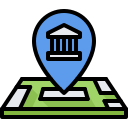
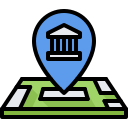
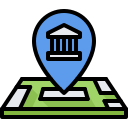
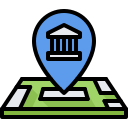
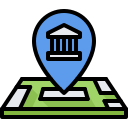
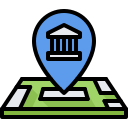
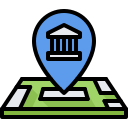
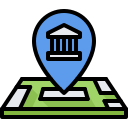
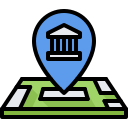
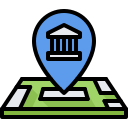
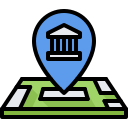
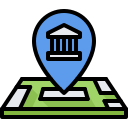
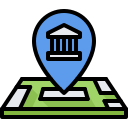
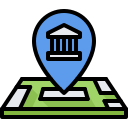
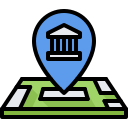
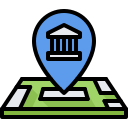
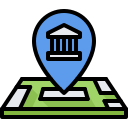
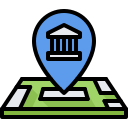
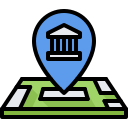
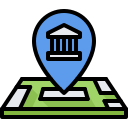
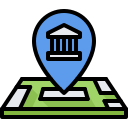
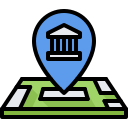
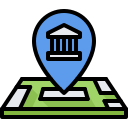
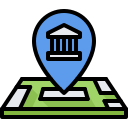
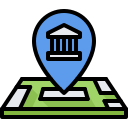
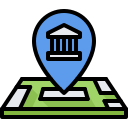
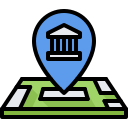
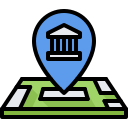
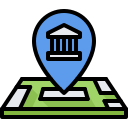
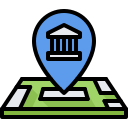
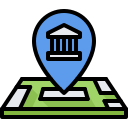
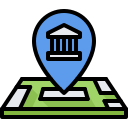
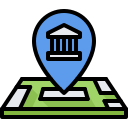
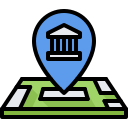
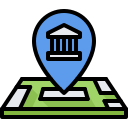
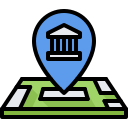
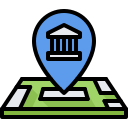
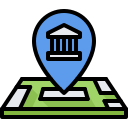
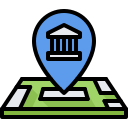
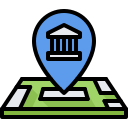
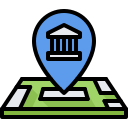
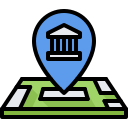
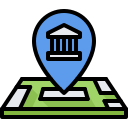
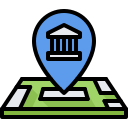
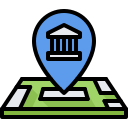
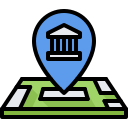
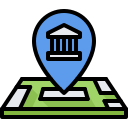
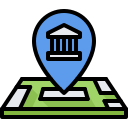
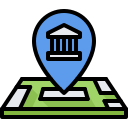
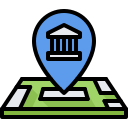
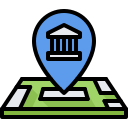
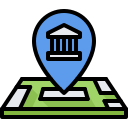
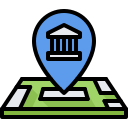
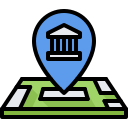
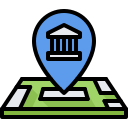
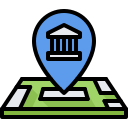
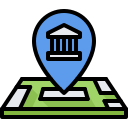
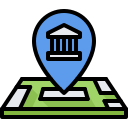
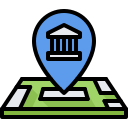
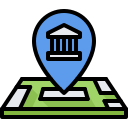

In [33]:
# Create a Folium map centered on Mexico City (OSM Bright)
map = folium.Map(location=[19.360765, -99.1276600], tiles='https://tiles.stadiamaps.com/tiles/osm_bright/{z}/{x}/{y}{r}.png', attr='&copy; <a href="https://stadiamaps.com/">Stadia Maps</a>, &copy; <a href="https://openmaptiles.org/">OpenMapTiles</a> &copy; <a href="http://openstreetmap.org">OpenStreetMap</a> contributors', zoom_start=11, max_zoom=13, control_scale=True)

# Create a Marker Cluster 
mCluster_Ch = MarkerCluster(name="Cuauhtémoc", options={'showCoverageOnHover': False,
                                        'zoomToBoundsOnClick': True,
                                        'spiderfyOnMaxZoom': False,
                                        'disableClusteringAtZoom': 13}).add_to(map)

# Add points to the map
for idx, row in museums.iterrows():
    # Define marker variables
    name = row['Museum']
    insta_post = "../Images/" + row["Image"] + ".JPG"
    website = row['WebSite']
    directions = ""
    
    # Create custom museum icon
    museum_img = 'Images/Museum2.png'
    custom_icon = folium.CustomIcon(museum_img, icon_size=(25, 25), popup_anchor=(0, -22))
    
    # Define html inside marker pop-up
    museum_html = folium.Html(f"""<p style="text-align: center;"><span style="font-family: Didot, serif; font-size: 21px;">{name}</span></p>
    <p style="text-align: center;"><img src={insta_post}></img></p>
    <p style="text-align: center;"><a href={website} target="_blank" title="Website"><span style="font-family: Didot, serif; font-size: 17px;">Web Site</span></a></p>
    """, script=True)
    
    # Create pop-up with html content
    popup = folium.Popup(museum_html, max_width=700)
    
    # Create marker with custom icon and pop-up.
    custom_marker = Marker([row['Latitude'], row['Longitude']], icon=custom_icon, tooltip=name, popup=popup) 
    custom_marker.add_to(map)
    
    # Add marker
    if row['TownHall'] == "Cuauhtémoc":
       mCluster_Ch.add_child(custom_marker)
    else:
        custom_marker.add_to(map)
   
# Show map
map

And finally, we create an interactive map with markers of the main museums in Mexico City and pop-up windows that show the names, images and websites of the museums, in which you can consult by town hall.

LayerControl allows you to add a layer control panel to your map that enables you to turn map layers on and off. You can use this to control the visibility of your markers, polygons, and other map elements.


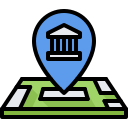
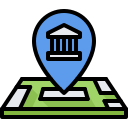
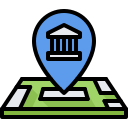
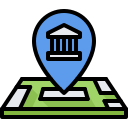
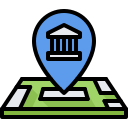
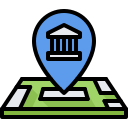
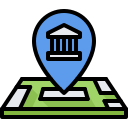
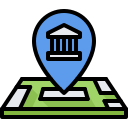
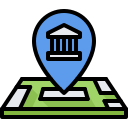
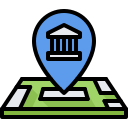
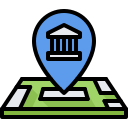
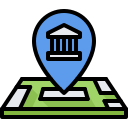
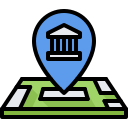
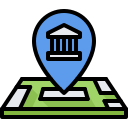
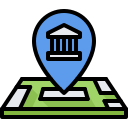
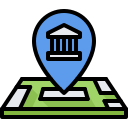
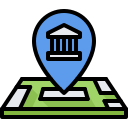
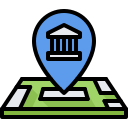
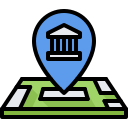
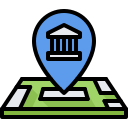
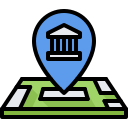
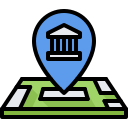
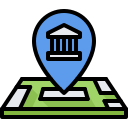
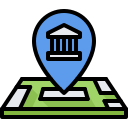
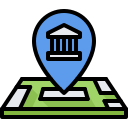
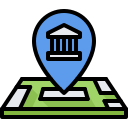
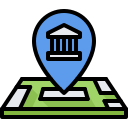
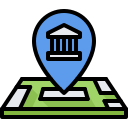
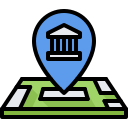
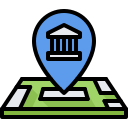
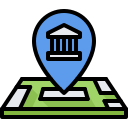
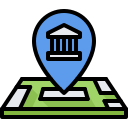
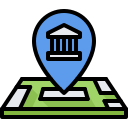
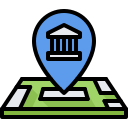
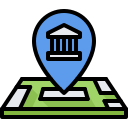
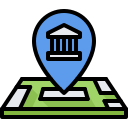
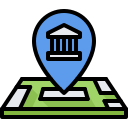
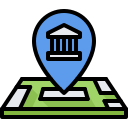
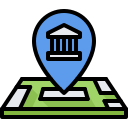
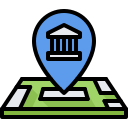
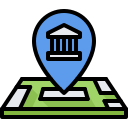
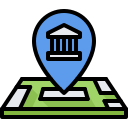
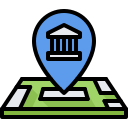
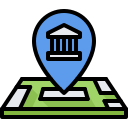
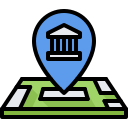
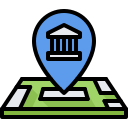
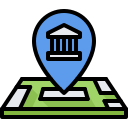
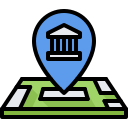
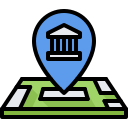
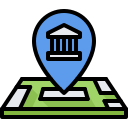
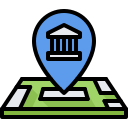
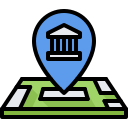
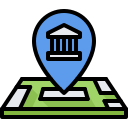
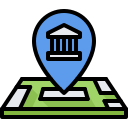
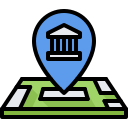
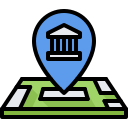
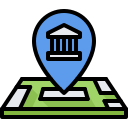
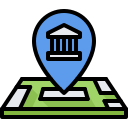
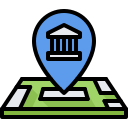
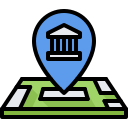

In [36]:
# Create a Folium map centered on Mexico City (OSM Bright)
interactive_map = folium.Map(location=[19.360765, -99.1276600], tiles='https://tiles.stadiamaps.com/tiles/osm_bright/{z}/{x}/{y}{r}.png', attr='&copy; <a href="https://stadiamaps.com/">Stadia Maps</a>, &copy; <a href="https://openmaptiles.org/">OpenMapTiles</a> &copy; <a href="http://openstreetmap.org">OpenStreetMap</a> contributors', zoom_start=11, max_zoom=13, control_scale=True)

# Create Feature Groups by Town Hall.
mCluster_AO = FeatureGroup(name="Alvaro Obregón").add_to(interactive_map)
mCluster_MH = FeatureGroup(name="Miguel Hidalgo").add_to(interactive_map)
mCluster_Ch = FeatureGroup(name="Cuauhtémoc").add_to(interactive_map)
mCluster_Co = FeatureGroup(name="Coyoacán").add_to(interactive_map)
mCluster_Tl = FeatureGroup(name="Tlalpan").add_to(interactive_map)
mCluster_Iz = FeatureGroup(name="Iztapalapa").add_to(interactive_map)
mCluster_GM = FeatureGroup(name="Gustavo A. Madero").add_to(interactive_map)
mCluster_Xo = FeatureGroup(name="Xochimilco").add_to(interactive_map)
mCluster_MC = FeatureGroup(name="Magdalena Contreras").add_to(interactive_map)
mCluster_Ic = FeatureGroup(name="Iztacalco").add_to(interactive_map)
mCluster_Az = FeatureGroup(name="Azcapotzalco").add_to(interactive_map)


# Add points to the map
for idx, row in museums.iterrows():
    # Define marker variables
    name = row['Museum']
    insta_post = "Images/" + row["Image"] + ".JPG"
    website = row['WebSite']
    directions = ""
    
    # Create custom museum icon
    museum_img = 'Images/Museum2.png'
    custom_icon = folium.CustomIcon(museum_img, icon_size=(25, 25), popup_anchor=(0, -22))
    
    
    # Define html inside marker pop-up
    museum_html = folium.Html(f"""<p style="text-align: center;"><span style="font-family: Didot, serif; font-size: 21px;">{name}</span></p>
    <p style="text-align: center;"><img src={insta_post}></img></p>
    <p style="text-align: center;"><a href={website} target="_blank" title="Website"><span style="font-family: Didot, serif; font-size: 17px;">Web Site</span></a></p>
    """, script=True)
    
    # Create pop-up with html content
    popup = folium.Popup(museum_html, max_width=700)
    
    # Create marker with custom icon and pop-up.
    custom_marker = Marker([row['Latitude'], row['Longitude']], icon=custom_icon, tooltip=name, popup=popup) 
    custom_marker.add_to(interactive_map)
    
    if row['TownHall'] == "Alvaro Obregón":
        mCluster_AO.add_child(custom_marker)
    elif row['TownHall'] == "Miguel Hidalgo":
        mCluster_MH.add_child(custom_marker)
    elif row['TownHall'] == "Cuauhtémoc":
        mCluster_Ch.add_child(custom_marker)
    elif row['TownHall'] == "Coyoacán":
        mCluster_Co.add_child(custom_marker)
    elif row['TownHall'] == "Tlalpan":
        mCluster_Tl.add_child(custom_marker)
    elif row['TownHall'] == "Iztapalapa":
        mCluster_Iz.add_child(custom_marker)
    elif row['TownHall'] == "Gustavo A. Madero":
        mCluster_GM.add_child(custom_marker)
    elif row['TownHall'] == "Xochimilco":
        mCluster_Xo.add_child(custom_marker)
    elif row['TownHall'] == "Magdalena Contreras":
        mCluster_MC.add_child(custom_marker)
    elif row['TownHall'] == "Iztacalco":
        mCluster_Ic.add_child(custom_marker)
    elif row['TownHall'] == "Azcapotzalco":
        mCluster_Az.add_child(custom_marker)
        


folium.LayerControl().add_to(interactive_map)
        
interactive_map

We also can add a menu bar to select museums with and without terrace, using the LayerControl class. 


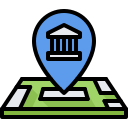
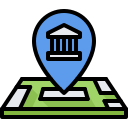
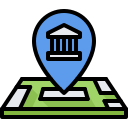
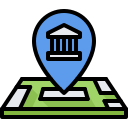
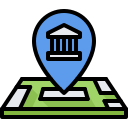
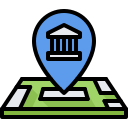
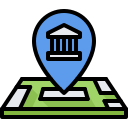
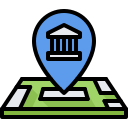
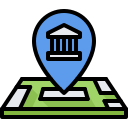
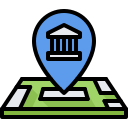
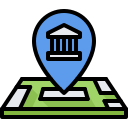
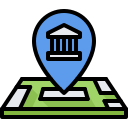
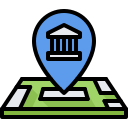
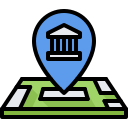
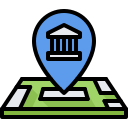
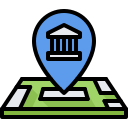
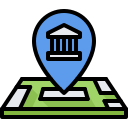
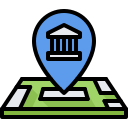
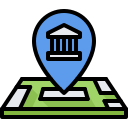
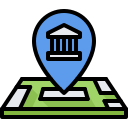
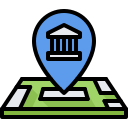
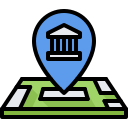
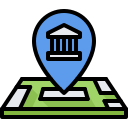
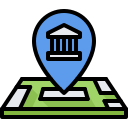
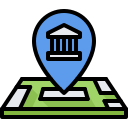
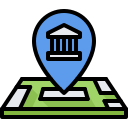
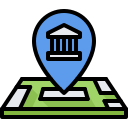
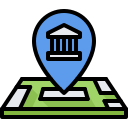
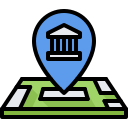
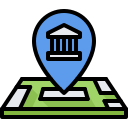
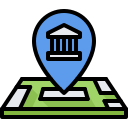
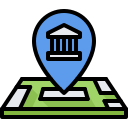
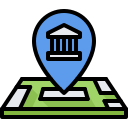
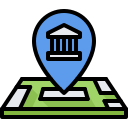
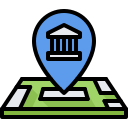
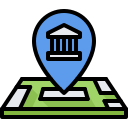
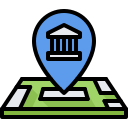
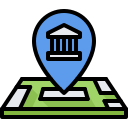
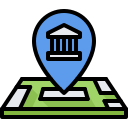
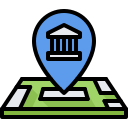
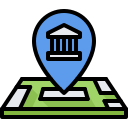
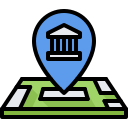
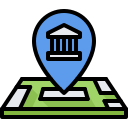
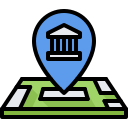
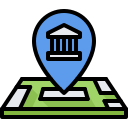
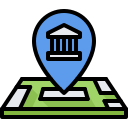
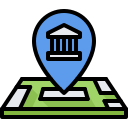
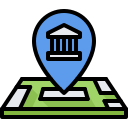
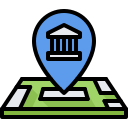
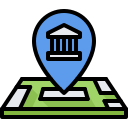
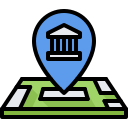
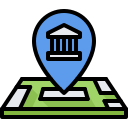
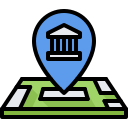
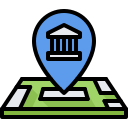
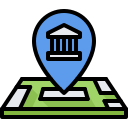
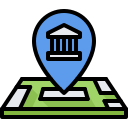
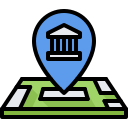
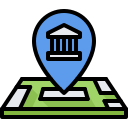
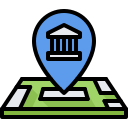
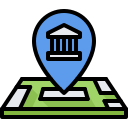

In [35]:
# Create a Folium map centered on Mexico City (OSM Bright)
map2 = folium.Map(location=[19.360765, -99.1276600], tiles='https://tiles.stadiamaps.com/tiles/osm_bright/{z}/{x}/{y}{r}.png', attr='&copy; <a href="https://stadiamaps.com/">Stadia Maps</a>, &copy; <a href="https://openmaptiles.org/">OpenMapTiles</a> &copy; <a href="http://openstreetmap.org">OpenStreetMap</a> contributors', zoom_start=11, max_zoom=13, control_scale=True)

# Create Feature Groups depending on Terrace property
mCluster_CT = FeatureGroup(name="Con Terraza").add_to(map2)
mCluster_ST = FeatureGroup(name="Sin Terraza").add_to(map2)


# Add points to the map
for idx, row in museums.iterrows():
    # Define marker variables
    name = row['Museum']
    insta_post = "Images/" + row["Image"] + ".JPG"
    website = row['WebSite']
    directions = ""
    
    # Create custom museum icon
    museum_img = 'Images/Museum2.png'
    custom_icon = folium.CustomIcon(museum_img, icon_size=(25, 25), popup_anchor=(0, -22))
    
    # Define html inside marker pop-up
    museum_html = folium.Html(f"""<p style="text-align: center;"><span style="font-family: Didot, serif; font-size: 21px;">{name}</span></p>
    <p style="text-align: center;"><img src={insta_post}></img></p>
    <p style="text-align: center;"><a href={website} target="_blank" title="Website"><span style="font-family: Didot, serif; font-size: 17px;">Web Site</span></a></p>
    """, script=True)
    
    # Create pop-up with html content
    popup = folium.Popup(museum_html, max_width=700)
    
    # Create marker with custom icon and pop-up.
    custom_marker = Marker([row['Latitude'], row['Longitude']], icon=custom_icon, tooltip=name, popup=popup) 
    custom_marker.add_to(map2)
    
    if row['Terrace'] == 0:
        mCluster_ST.add_child(custom_marker)
    else:
        mCluster_CT.add_child(custom_marker)

folium.LayerControl().add_to(map2)
        
map2

We add a menu bar to select museums dependeing if I have visited them. In this case we will use un different icon depending if I have visited the museum or not.


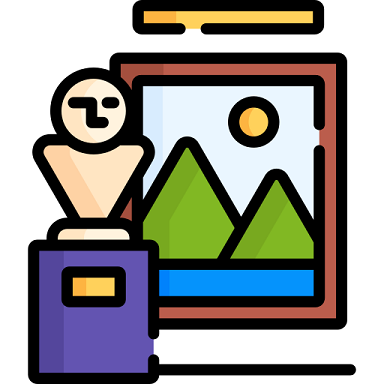
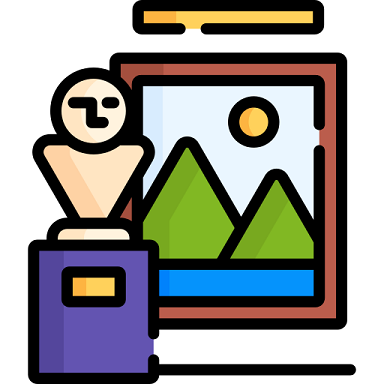
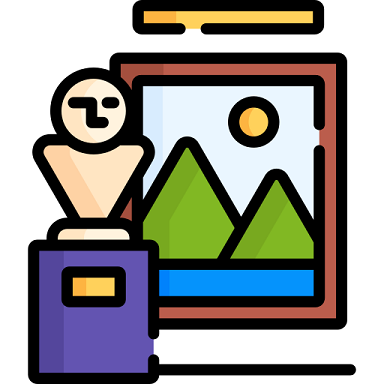
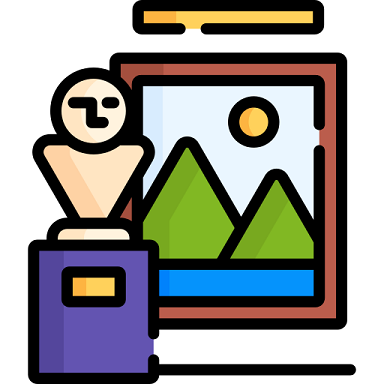
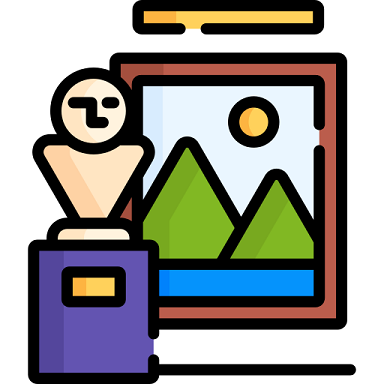
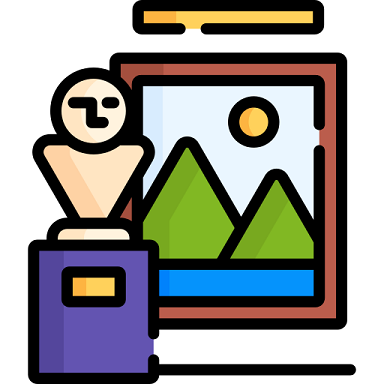
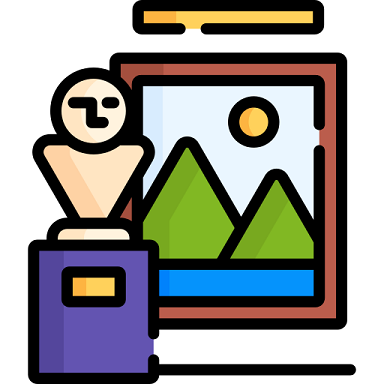
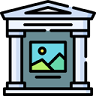
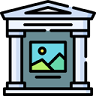
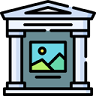
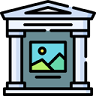
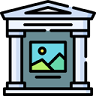
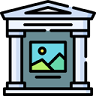
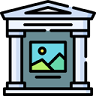
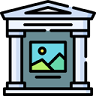
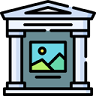
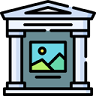
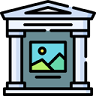
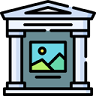
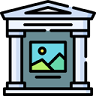
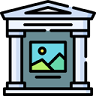
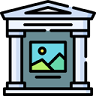
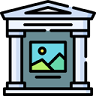
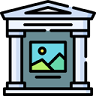
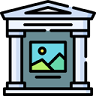
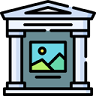

In [23]:
# Create a Folium map centered on Mexico City (OSM Bright)
map3 = folium.Map(location=[19.360765, -99.1276600], tiles='https://tiles.stadiamaps.com/tiles/osm_bright/{z}/{x}/{y}{r}.png', attr='&copy; <a href="https://stadiamaps.com/">Stadia Maps</a>, &copy; <a href="https://openmaptiles.org/">OpenMapTiles</a> &copy; <a href="http://openstreetmap.org">OpenStreetMap</a> contributors', zoom_start=11, max_zoom=13, control_scale=True)

# Create Feature Groups depending on Visited property
mCluster_V = FeatureGroup(name="Visited").add_to(map3)
mCluster_NV = FeatureGroup(name="Not Visited").add_to(map3)


# Add points to the map
for idx, row in museums.iterrows():
    # Define marker variables
    name = row['Museum']
    insta_post = ".Images/" + row["Image"] + ".JPG"
    website = row['WebSite']
    directions = ""
    
    # Create custom museum icon
    museum_img_v = 'Images/Museum_v.png'
    #custom_icon_nv = folium.CustomIcon(museum_img, icon_size=(25, 25), popup_anchor=(0, -22))
    museum_img_nv = 'Images/Museum_nv.png'
    if row['Visited'] == 1:
        custom_icon = folium.CustomIcon(museum_img_v, icon_size=(25, 25), popup_anchor=(0, -22))
    else:
        custom_icon = folium.CustomIcon(museum_img_nv, icon_size=(25, 25), popup_anchor=(0, -22))
    
    
    # Define html inside marker pop-up
    museum_html = folium.Html(f"""<p style="text-align: center;"><span style="font-family: Didot, serif; font-size: 21px;">{name}</span></p>
    <p style="text-align: center;"><img src={insta_post}></img></p>
    <p style="text-align: center;"><a href={website} target="_blank" title="Website"><span style="font-family: Didot, serif; font-size: 17px;">Web Site</span></a></p>
    """, script=True)
    
    # Create pop-up with html content
    popup = folium.Popup(museum_html, max_width=700)
    
    # Create marker with custom icon and pop-up.
    custom_marker = Marker([row['Latitude'], row['Longitude']], icon=custom_icon, tooltip=name, popup=popup) 
    custom_marker.add_to(map3)
    
    if row['Visited'] == 1:
        mCluster_V.add_child(custom_marker)
    else:
        mCluster_NV.add_child(custom_marker)

folium.LayerControl().add_to(map3)

# Show map
map3